# DP based query estimation

## Mean estimation

In [ ]:
import numpy as np
np.random.seed(42)

In [ ]:
def dp_mean_estimation(data, epsilon):

    return true_mean + noise


## Median selection

In [ ]:
def dp_median_exponential(data, epsilon):
    data = np.sort(data)
    n = len(data)

    # Utility function: negative absolute deviation from median
    scores = np.array([-abs(np.sum(data < x) - np.sum(data > x)) for x in data])

    # Exponential Mechanism
    exp_weights = np.exp(epsilon * scores / 2)
    probabilities = exp_weights / np.sum(exp_weights)

    return np.random.choice(data, p=probabilities)


## Counting queries can use randomized response or laplace mechanism

In [ ]:
def dp_count_laplace(data, predicate, epsilon):
    # data: list of records
    # predicate: function mapping record → {0,1}
    true_count = sum(predicate(x) for x in data)

    # Laplace noise
    noise = np.random.laplace(loc=0.0, scale=1.0 / epsilon)

    return true_count + noise

## histogram

### 1-D, let's say we want to realse the ages of people in a neighbourhood using DP

Original counts: [132  51  62  81  90  87  84  76  89  60  49  38  45  19  11   9   7   7
   1   2]
Laplace noise: [-0.52046726 -4.74514314 -0.55348229 -8.9052259   0.06119321  1.6752249
  4.00136501 -0.6064159   5.86832476  0.47206291  2.85062365  8.40722759
 -2.16287935  4.6208886   0.40802869  0.79426835  1.55694959  2.13476432
  0.76291865  1.54102763]


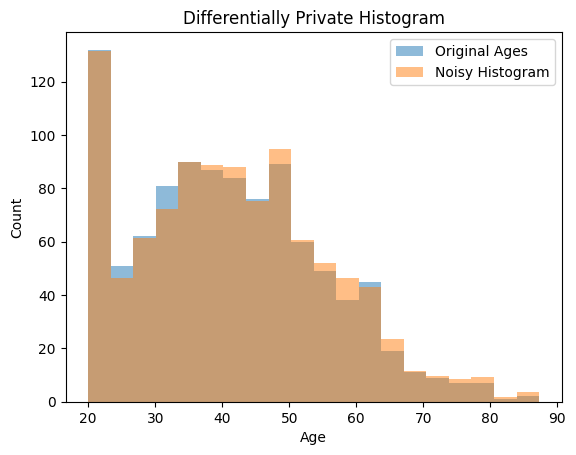

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(29)
n = 1000

# Step 1: Generate the data
ages = np.clip(np.random.normal(loc=40, scale=15, size=n), 20, 100)

# Step 2: Compute histogram
count, bins = np.histogram(ages, bins=20)
print("Original counts:", count)

# Step 3: Plot the original histogram
plt.hist(ages, bins=20, alpha=0.5, label='Original Ages')

# Step 4: Add Laplace noise for differential privacy
epsilon = 1
laplace_noise = np.random.laplace(loc=0, scale=2/epsilon, size=20)
print("Laplace noise:", laplace_noise)

# Step 5: Add noise to counts and clip negatives
noisy_count = count.astype(float) + laplace_noise
noisy_count = np.clip(noisy_count, 0, None)  # Ensure counts are non-negative

# Step 6: Plot the noisy histogram using the same bins
plt.hist(bins[:-1], bins=bins, weights=noisy_count, alpha=0.5, label='Noisy Histogram')

plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Differentially Private Histogram')
plt.show()


What if there is an entry with 1 count and after adding noise we get 1.4?
DP does not stop an adversary from seeing 1.4. It stops them from saying: “This person definitely smokes.” We might have got 1.4 from 0,1,2.
The guarantee is that this result is nearly as likely whether or not any one person is in the data. In practice, we suppress, round, or use thresholding small counts to avoid interpretability that can lead to harmful inferences.

How You Handle Small Counts in Practice
Real-world systems go further to reduce this kind of leakage:

Technique	Why It's Used
Binning	Aggregates data to reduce sparsity
Suppressing low-count bins	Drop bins with small/noisy counts below a threshold
Clamping noise	Clip noisy outputs to reduce extreme values
Public use microdata	Use synthetic sampling from DP histograms (like we did)
Post-processing (rounding)	Round noisy counts to reduce interpretability of decimals
For example, the US Census uses a thresholding step after adding noise — bins below a noisy count (e.g., < 3) are suppressed or zeroed out to avoid the exact problem.


In [ ]:
pmf = noisy_count / np.sum(noisy_count)

# Step 4: Sample bins according to the PMF
num_synthetic = 1000
chosen_bins = np.random.choice(len(pmf), size=num_synthetic, p=pmf)

# Step 5: Generate synthetic data by sampling uniformly within the bin range
synthetic_data = np.array([
    np.random.uniform(low=bins[i], high=bins[i+1])
    for i in chosen_bins
])
hist, bins = np.histogram(synthetic_data, bins=20)
print("Synthetic counts:", hist)

Synthetic counts: [138  45  64  78  81  68  86  73  97  49  55  44  49  23   5  15  15   6
   6   3]


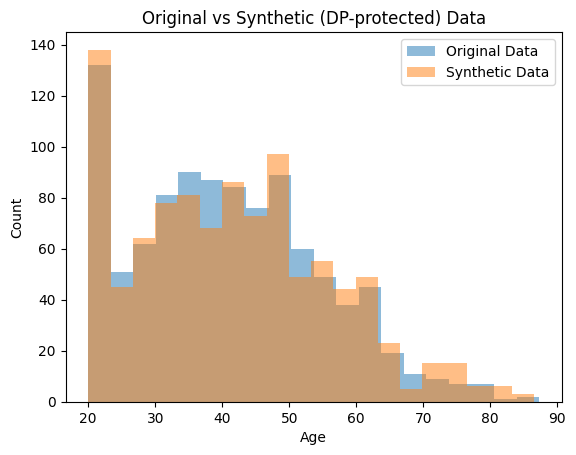

In [ ]:
plt.hist(ages, bins=20, alpha=0.5, label='Original Data')
plt.hist(synthetic_data, bins=20, alpha=0.5, label='Synthetic Data')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Original vs Synthetic (DP-protected) Data')
plt.show()

# Logistic Regression

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Generating good data that can be used for logistic regression

def generate_spherical_logistic_data(n_samples=1000, n_dim=2, radius=5.0, margin=0.7, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.randn(n_samples, n_dim)
    X /= np.linalg.norm(X, axis=1, keepdims=True)  # Normalize to sphere
    scales = np.random.rand(n_samples, 1) ** (1 / n_dim)  # Radius scaling
    X *= radius * scales
    # Generate a random separating hyperplane
    w_star = np.random.randn(n_dim)
    w_star /= np.linalg.norm(w_star)
    logits = X @ w_star

    #ind = np.where((logits > -margin) & (logits < margin))[0]
    #X = np.delete(X, ind, axis=0)
    #logits = np.delete(logits, ind)
    y = (logits > margin).astype(int)
    ind = np.where((logits > -margin) & (logits < margin))[0]
    for i in ind:
      pr = np.random.rand()
      if pr > 0.5:
        y[i] = 1
      else:
        y[i] = 0
    return X, y, w_star


[0.97906764 0.20353513]


Text(0, 0.5, 'X2')

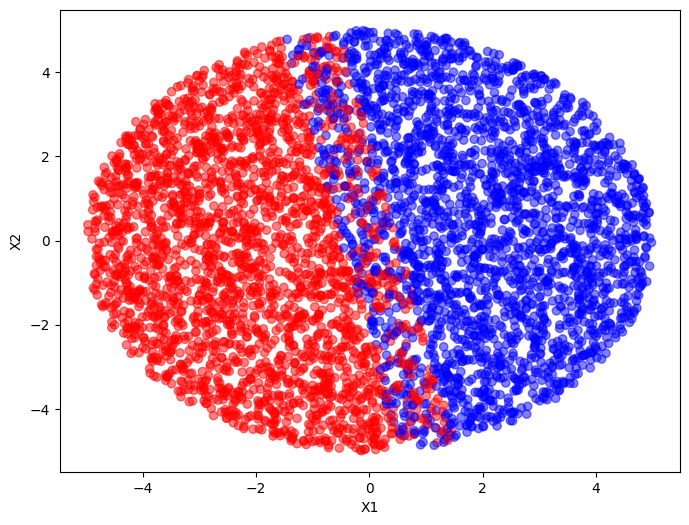

In [ ]:
plt.figure(figsize=(8, 6))
X, y, w_star = generate_spherical_logistic_data(n_samples=5000, n_dim=2, radius=5.0, margin=0.5, seed=42)
print(w_star)
n = len(X)
arr = np.random.randint(0, n, 100)
X_test, y_test = X[arr], y[arr]
plt.scatter(X[:, 0], X[:, 1], c=['red' if label == 0 else 'blue' for label in y], alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')

## Non private Logistic Regression

In [ ]:
def train_logistic_regression(X, y, lr=0.1, epochs=300, lam=0.0, tol=1e-2, verbose=True):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    arr = []
    for i in range(epochs):
        loss, grad = logistic_loss_and_grad(X, y, w, lam)
        w -= lr * grad
        if verbose and i % 100 == 0:
            arr.append(w)
            print(f"Epoch {i}, Loss: {loss:.4f}")
        if np.linalg.norm(grad) < tol:
            break
    return w, arr

In [ ]:
def sample_laplace_noise(d, n, epsilon, lam, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Step 1: Sample radius from Gamma(d, 2 / (n * ε * λ))
    sf = (n * epsilon * lam)
    scale = 2 / (n * epsilon * lam)
    radius = np.random.gamma(shape=d, scale=scale)
    # Step 2: Sample direction uniformly from the unit sphere
    direction = np.random.randn(d)
    direction /= np.linalg.norm(direction)
    # Combine to form η
    eta = radius * direction
    return eta

In [ ]:
eta = sample_laplace_noise(2,1000,0.1,0.1,42)
print(eta)

[-0.05907666 -0.47507682]


## method 1: Output perturbation

In [ ]:
def train_logistic_regression_private(X, y, lr=0.1, epochs=300, lam=0.1, tol=1e-2, verbose=True, eps=0.1):
    w_report = []
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for i in range(epochs):
        loss, grad = logistic_loss_and_grad(X, y, w, lam)
        w -= lr * grad
        if verbose and i % 100 == 0:
            s = sample_laplace_noise(n_features,1000,eps,lam, 42)
            w_report.append(w + s)
            print(f"Epoch {i}, Loss: {loss:.4f}")
        if np.linalg.norm(grad) < tol:
            break
    s = sample_laplace_noise(n_features,1000,eps,lam, 42)
    return w + s,w_report

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss_and_grad(X, y, w, lam=0.0):
    lam = 0
    n = X.shape[0]
    z = X @ w
    preds = sigmoid(z)

    # Loss with L2 regularization
    loss = -np.mean(y * np.log(preds + 1e-9) + (1 - y) * np.log(1 - preds + 1e-9)) + (lam / 2) * np.sum(w**2)

    # Gradient with L2
    grad = (X.T @ (preds - y)) / n + lam * w
    return loss, grad

d (int): Dimension of the vector
        n (int): Number of samples
        epsilon (float): Privacy budget
        lam (float): Regularization parameter λ
        seed (int): Random seed for reproducibility (optional)

In [ ]:
w, arr = train_logistic_regression(X, y, lr=0.1, epochs=1000, lam=0.1, tol=1e-6, verbose=True)
loss,grad = logistic_loss_and_grad(X_test, y_test, w, lam=0.1)
print(w)

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2578
Epoch 200, Loss: 0.2577
Epoch 300, Loss: 0.2577
Epoch 400, Loss: 0.2577
[-0.93246793  0.72834599]


In [ ]:
w1, arr1 = train_logistic_regression_private(X, y, lr=0.1, epochs=1000, lam=0.1, tol=1e-6, verbose=True, eps=0.1)
loss1,grad1 = logistic_loss_and_grad(X_test, y_test, w1, lam=0.1)
print(w1)

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2578
Epoch 200, Loss: 0.2577
Epoch 300, Loss: 0.2577
Epoch 400, Loss: 0.2577
[-0.99154459  0.25326916]


In [ ]:
loss, grad = logistic_loss_and_grad(X_test, y_test, w, lam=0.1)
loss1, grad1 = logistic_loss_and_grad(X_test, y_test, w1, lam=0.1)
print(loss, loss1)

0.2538650756124896 0.3442314093720531


In [ ]:
n = np.arange(0,4)
loss_arr = []
loss_arr1 = []
for i in n:
  loss,grad = logistic_loss_and_grad(X_test, y_test, arr[i], lam=0.1)
  loss1,grad1 = logistic_loss_and_grad(X_test, y_test, arr1[i], lam=0.1)
  loss_arr1.append(loss1)
  loss_arr.append(loss)

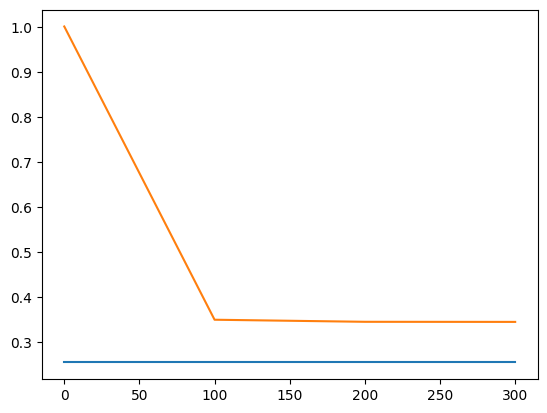

In [ ]:
plt.plot(100*n,loss_arr)
plt.plot(100*n,loss_arr1)

## method 2: Objective perturbation

In [ ]:
def private_logistic_loss_and_grad(X, y, w,b, lam=0.1):
    n = X.shape[0]
    z = X @ w
    preds = sigmoid(z)
    noise = w @ b
    loss = -np.mean(y * np.log(preds + 1e-9) + (1 - y) * np.log(1 - preds + 1e-9)) + (lam / 2) * np.sum(w**2)
    grad = (X.T @ (preds - y)) / n + lam * w + b/n
    return loss, grad

In [ ]:
def sample_laplace_noise_1(d, epsilon, seed=None):
    if seed is not None:
        np.random.seed(seed)
    scale = 2 /epsilon
    radius = np.random.gamma(shape=d, scale=scale)
    # Step 2: Sample direction uniformly from the unit sphere
    direction = np.random.randn(d)
    direction /= np.linalg.norm(direction)
    # Combine to form η
    eta = radius * direction
    return eta

In [ ]:
def train_logistic_regression_private2(X, y, lr=0.1, epochs=300, lam=0.0, tol=1e-6, verbose=True):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = sample_laplace_noise_1(n_features, 0.1, 41)
    arr = []
    for i in range(epochs):
        loss, grad = private_logistic_loss_and_grad(X, y, w, b, lam)
        w -= lr * grad
        if verbose and i % 100 == 0:
            arr.append(w)
            print(f"Epoch {i}, Loss: {loss:.4f}")
        if np.linalg.norm(grad) < tol:
            break
    return w, arr

In [ ]:
w2, arr2 = train_logistic_regression_private2(X, y, lr=0.1, epochs=1000, lam=0.1, tol=1e-6, verbose=True)
loss,grad = logistic_loss_and_grad(X_test, y_test, w, lam=0.1)
print(loss)
print(w2)

Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2578
Epoch 200, Loss: 0.2577
Epoch 300, Loss: 0.2577
Epoch 400, Loss: 0.2577
0.2538650756124896
[-0.93601041  0.73395039]


[np.float64(0.2538650756124896), np.float64(0.2538650756124896), np.float64(0.2538650756124896), np.float64(0.2538650756124896)]
[np.float64(1.0022276676534736), np.float64(0.34907324430631853), np.float64(0.3444647227587595), np.float64(0.3442427122726841)]
[np.float64(0.25385472505205553), np.float64(0.25385472505205553), np.float64(0.25385472505205553), np.float64(0.25385472505205553)]


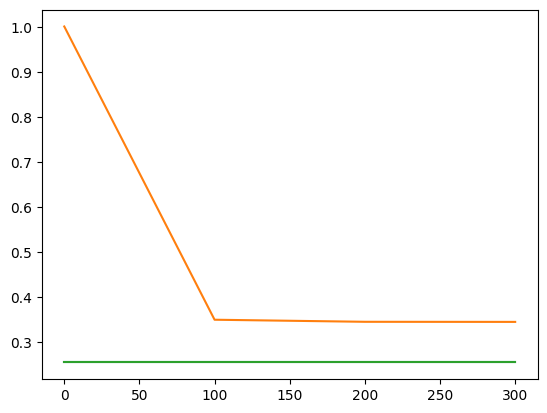

In [ ]:
loss_arr2=[]
for i in n:
  loss, grad = logistic_loss_and_grad(X_test, y_test, arr2[i], lam=0.1)
  loss_arr2.append(loss)
print(loss_arr)
print(loss_arr1)
print(loss_arr2)
plt.plot(100*n,loss_arr2)
plt.plot(100*n,loss_arr1)
plt.plot(100*n,loss_arr)

## method 3: DP-SGD based Logistic Regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Generate synthetic binary classification data
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape [N, 1]
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 2. Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegression(input_dim=20)

# 3. Optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCELoss()

# 4. Attach Opacus PrivacyEngine
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=2.0,
    target_delta=1e-5,
    epochs=10,
    max_grad_norm=1.0,
)

# 5. Train
for epoch in range(10):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | ε = {privacy_engine.get_epsilon(1e-5):.2f}")

# 6. Final epsilon
final_epsilon = privacy_engine.get_epsilon(1e-5)
print(f"\nTraining done with ε = {final_epsilon:.2f}, δ = 1e-5")


ModuleNotFoundError: No module named 'opacus'

# Linear Regression

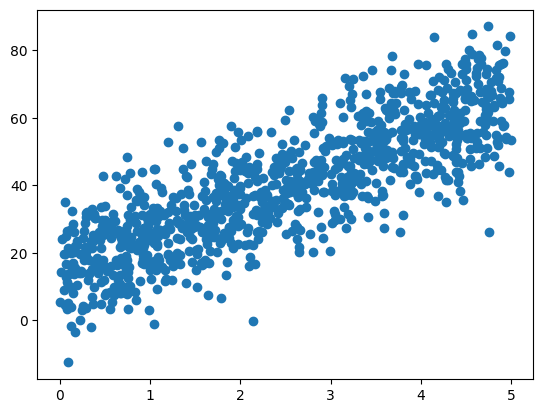

In [ ]:
a = 10
b = 5
X = 5*np.random.rand(1,1000)
X = X[0,:]
e = np.random.normal(10, 10, (1,1000))
e = e[0,:]
y = a*X + b + e
plt.scatter(X,y)

## Non private Linear regression

In [ ]:
def Linear_regression(X,y):
  a = np.cov(X,y)/np.var(X)
  a = a[0][1]
  b = np.mean(y) - np.mean(X)*a
  return a,b

In [ ]:
w = Linear_regression(X,y)
print(w)

(np.float64(10.282630603887059), np.float64(14.550248307113762))


## method 1: Noisy_stats(Output perturbation) non robust

In [ ]:
aa = np.cov(X,y)/np.var(X)
aa = aa[0][1]
bb = np.mean(y) - np.mean(X)*aa
print(aa,bb)

10.282630603887059 14.550248307113762


In [ ]:
def Private_linear_regression(X,y,eps):
  n = X.shape[0]
  sensitivity = 1 - 1/n
  l1 = np.random.laplace(0,3*sensitivity/eps)
  l2 = np.random.laplace(0,3*sensitivity/eps)
  if(np.var(X) > 0):
    aa = np.cov(X,y)/np.var(X)
    aa = aa[0][1]
    bb = np.mean(y) - np.mean(X)*aa
    return aa + l1, bb + l2

In [ ]:
aa,bb = Private_linear_regression(X,y,1)
print(aa,bb)
aa,bb = Private_linear_regression(X,y,0.1)
print(aa,bb)

13.273822900816636 4.4803893924935565
35.80258315037342 -24.50768729308956


lesser values of e blow up the error, this kind of error analysis we can do when we know theory. How parameters affect utility and error

## method 2: DP-Theilsen(Robust estimator)

In [ ]:
def DP_Theilsen(X,y,eps):
    n = X.shape[0]
    arr1 = np.random.randint(0,1000,n)
    arr2 = np.random.randint(0,1000,n)
    X1 = X[arr1]
    X2 = X[arr2]
    y1 = y[arr1]
    y2 = y[arr2]
    m = (y2 - y1)/[(X2 - X1) + 1e-6]
    m = m[0,:]
    a = dp_median_exponential(m,eps)
    b = np.mean(y1) - a*np.mean(X1)
    return a,b

In [ ]:
a,b = DP_Theilsen(X,y,1)
print(a,b)

9.735055390378845 16.14867072830166


In [ ]:
a,b = DP_Theilsen(X,y,0.1)
print(a,b)

10.142704183510265 15.490132524659607


## method 3: DP-SGD based Linear Regression